In [ ]:
'''

Team 81

Adam McMillan 1393533
Ryan Kuang 1547320
Tim Shen 1673715
Yili Liu 883012
Yuting Cai 1492060

'''

SyntaxError: invalid non-printable character U+00A0 (3911603724.py, line 1)

### 1. Package Dependencies

Importing the following packages allows running all cells in this notebook.

In [2]:
# Standard library
import json  # For working with JSON data
import math  # For mathematical functions like log
import warnings  # For controlling warning messages
from pprint import pprint  # For printing jsons by lines
from datetime import datetime  # For working with date and time objects

# Third-party libraries
import requests  # For making HTTP requests
from requests.auth import HTTPBasicAuth  # For handling basic HTTP authentication
from urllib3.exceptions import InsecureRequestWarning  # For suppressing SSL warnings
import pandas  # for structured data aggregation, eg. time-based grouping
import numpy  # For numerical computing and array operations
import matplotlib.pyplot as plt  # For plotting graphs and visualisations
import matplotlib.patches as mpatches  # For creating custom plot elements like legends and shapes
import plotly.express as px
from scipy.stats import linregress  # For performing linear regression analysis
from scipy.stats import ttest_ind  # For performing independent t-tests between two samples
from dateutil.relativedelta import relativedelta  # For date manipulations with relative offsets

### 2. Querying Artist Mention Counts via API

Send a GET request to API endpoint '/mention-count-by-artist-final', while option to query Elasticsearch directly is also included but commented out.

Either way, the query returns the total mention counts for each artist, stored into result_count_api as a JSON response. 

In [3]:
warnings.simplefilter('ignore', InsecureRequestWarning)

'''
# Use ES to query
url = "https://localhost:9200/artists/_search"
auth = HTTPBasicAuth("elastic", "elastic")
'''

# Use API to query
headers = {"Content-Type": "application/json"}
try:
    response = requests.get(
        "http://localhost:9090/mention-count-by-artist-final",
        headers=headers,
        verify=False
    )
    if response.status_code == 200:
        count_via_api = response.json()
        pprint(count_via_api, sort_dicts=False)
    else:
        print(f"Error: {response.status_code} {response.text}")
        count_via_api = {}
except Exception as e:
    print(f"Request failed: {str(e)}")
    count_via_api = {}

{'international': [['`          Bruno Mars', 2],
                   ['`           Lady Gaga', 29],
                   ['`          The Weeknd', 1],
                   ['`       Billie Eilish', 59],
                   ['`            Coldplay', 34],
                   ['`             Rihanna', 17],
                   ['`      Kendrick Lamar', 29],
                   ['`          Ed Sheeran', 35],
                   ['`        Taylor Swift', 331],
                   ['`           Bad Bunny', 4],
                   ['`       Ariana Grande', 3],
                   ['`               Drake', 42],
                   ['`       Justin Bieber', 5],
                   ['`                 SZA', 6],
                   ['`        David Guetta', 1],
                   ['`            Maroon 5', 0],
                   ['`         Post Malone', 4],
                   ['`       Calvin Harris', 1],
                   ['`            Dua Lipa', 11],
                   ['`              Eminem', 18],
         

### 3. Plot Total Count

Logarithm taken to make all bars visible. 

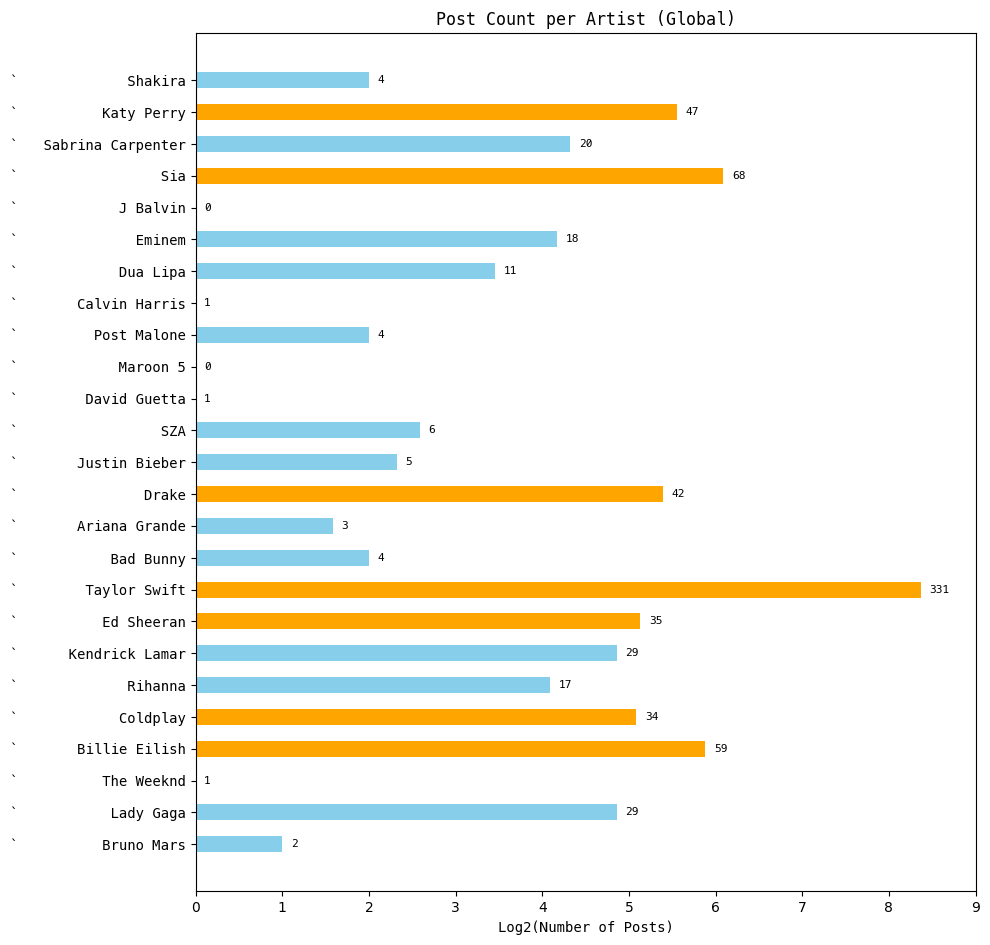

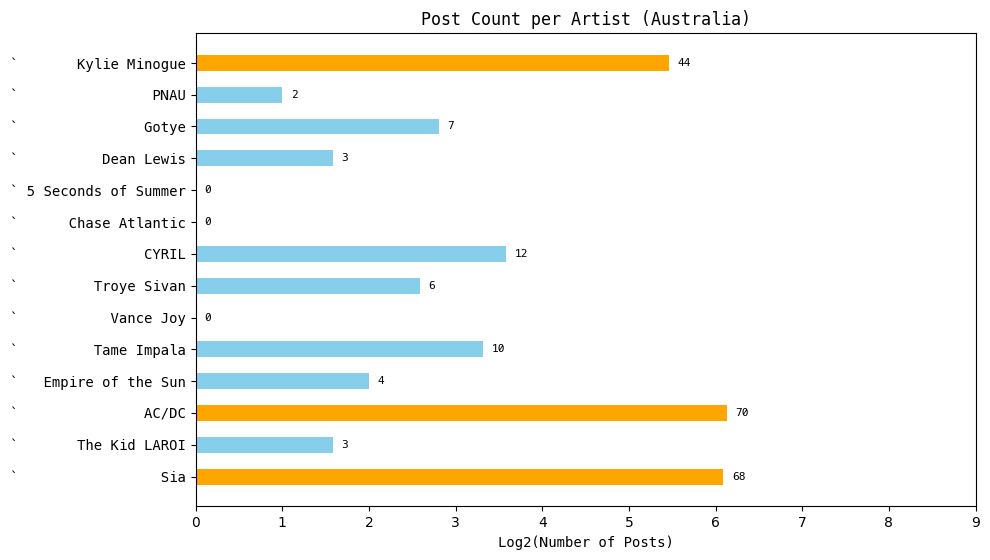

In [4]:
def plot_results(artist_list, title, x_limit):
    artists = [artist for artist, _ in artist_list]
    counts = [count for _, count in artist_list]

    log_counts = [math.log2(c) if c > 1 else 0 for c in counts]
    colors = ['orange' if c > 32 else 'skyblue' for c in counts]

    plt.figure(figsize=(10, len(artists) * 0.35 + 0.8))
    bars = plt.barh(artists, log_counts, color=colors, height=0.5)

    plt.xlabel("Log2(Number of Posts)", fontname='Menlo')
    plt.title(title, fontname='Menlo')
    plt.xlim(0, x_limit)
    plt.yticks(fontname='Menlo')

    for bar, count, log_count in zip(bars, counts, log_counts):
        label = str(count)
        plt.text(log_count + 0.1, bar.get_y() + bar.get_height() / 2, label, va='center', fontname='Menlo', fontsize=8)

    plt.tight_layout()
    plt.show()


plot_results(count_via_api['international'], "Post Count per Artist (Global)", x_limit=9)
plot_results(count_via_api['australia'], "Post Count per Artist (Australia)", x_limit=9)

### 4. Plot Monthly Listener Rank against Mention Count

Does monthly listeners ranks of artists affect the amount of discussions? Do a linear regression to find out.


[Social Media Mentions vs Listening Rank (Global)]
Slope: 1.085, Intercept: 16.740, R²: 0.0148, p-value: 0.5621
Top residual outliers:
`          Bruno Mars - Residual: 41.86, Rank: 25, Posts: 2
`                 Sia - Residual: 46.92, Rank: 4, Posts: 68
`        Taylor Swift - Residual: 295.82, Rank: 17, Posts: 331


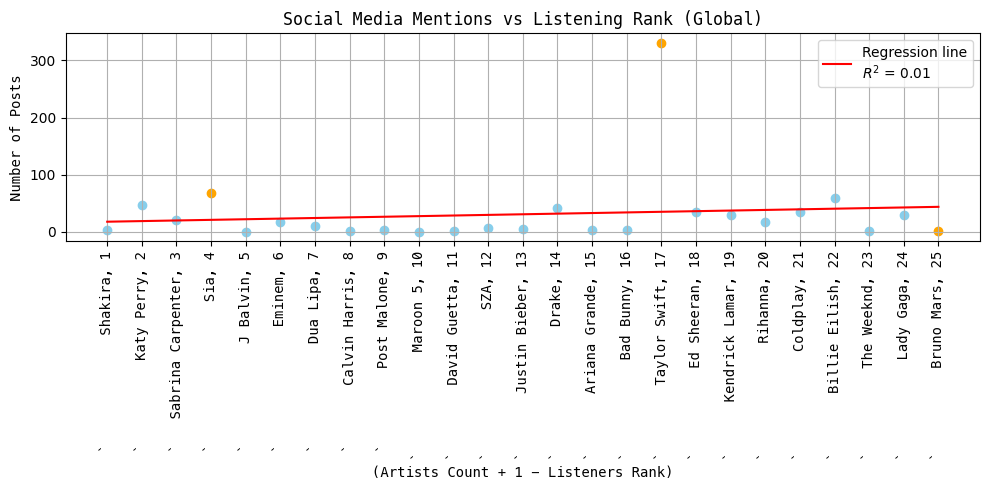


[Social Media Mentions vs Listening Rank (Australia)]
Slope: 2.068, Intercept: 0.846, R²: 0.1204, p-value: 0.2242
Top residual outliers:
`                 Sia - Residual: 38.20, Rank: 14, Posts: 68
`       Kylie Minogue - Residual: 41.09, Rank: 1, Posts: 44
`               AC/DC - Residual: 44.34, Rank: 12, Posts: 70


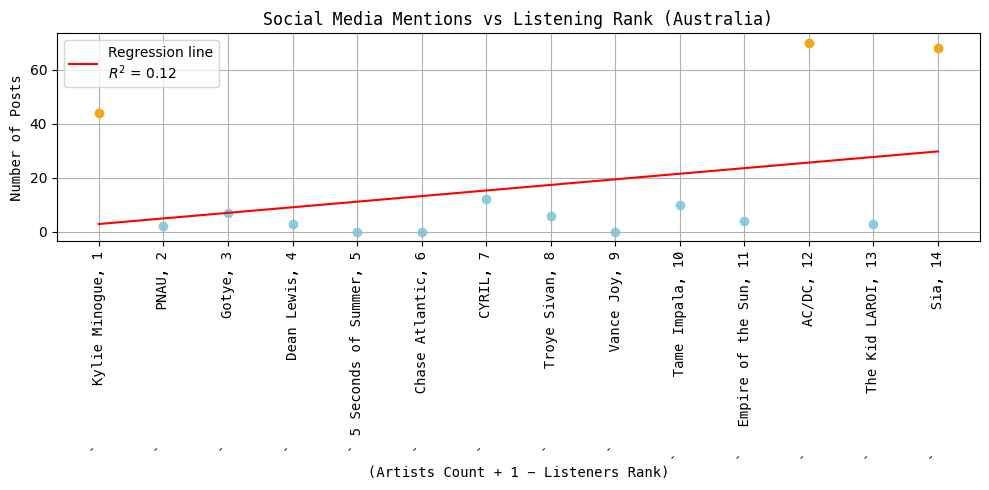

In [5]:
def plot_rank_vs_post_count(artist_list, title, outlier_count=3):
    n = len(artist_list)
    ranks = [n - i for i in range(n)]
    counts = [count for _, count in artist_list]
    names = [name for name, _ in artist_list]

    xtick_labels = [f"{name}, {rank}" for name, rank in zip(names, ranks)]

    # Regression analysis
    slope, intercept, r_value, p_value, std_err = linregress(ranks, counts)
    predictions = [slope * x + intercept for x in ranks]
    residuals = [abs(actual - pred) for actual, pred in zip(counts, predictions)]
    outlier_indices = numpy.argsort(residuals)[-outlier_count:]
    print(f"\n[{title}]")
    print(f"Slope: {slope:.3f}, Intercept: {intercept:.3f}, R²: {r_value**2:.4f}, p-value: {p_value:.4f}")
    print("Top residual outliers:")
    for i in outlier_indices:
        print(f"{names[i]} - Residual: {residuals[i]:.2f}, Rank: {ranks[i]}, Posts: {counts[i]}")

    # Plot
    fig, ax = plt.subplots(figsize=(10, 5))
    for i in range(n):
        color = 'orange' if i in outlier_indices else 'skyblue'
        ax.scatter(ranks[i], counts[i], color=color)

    ax.plot(ranks, predictions, color='red', label=f'Regression line\n$R^2$ = {r_value**2:.2f}')
    ax.set_title(title, fontname='Menlo')
    ax.set_xlabel("(Artists Count + 1 - Listeners Rank)", fontname='Menlo')
    ax.set_ylabel("Number of Posts", fontname='Menlo')
    ax.set_xticks(ranks)
    ax.set_xticklabels(xtick_labels, rotation='vertical', fontname='Menlo')
    ax.legend()
    ax.grid(True)
    plt.tight_layout()
    plt.show()


plot_rank_vs_post_count(count_via_api['international'], "Social Media Mentions vs Listening Rank (Global)")
plot_rank_vs_post_count(count_via_api['australia'], "Social Media Mentions vs Listening Rank (Australia)")

### 5. Get Artists with 5 Post or More

Leaving out artists with too few mentions. Re-plot the counts just for reference.

Filtered Global Artists (≥5 posts):
[('`           Lady Gaga', 29),
 ('`       Billie Eilish', 59),
 ('`            Coldplay', 34),
 ('`             Rihanna', 17),
 ('`      Kendrick Lamar', 29),
 ('`          Ed Sheeran', 35),
 ('`        Taylor Swift', 331),
 ('`               Drake', 42),
 ('`       Justin Bieber', 5),
 ('`                 SZA', 6),
 ('`            Dua Lipa', 11),
 ('`              Eminem', 18),
 ('`                 Sia', 68),
 ('`   Sabrina Carpenter', 20),
 ('`          Katy Perry', 47)]
15

Filtered Australian Artists (≥5 posts):
[('`                 Sia', 68),
 ('`               AC/DC', 70),
 ('`         Tame Impala', 10),
 ('`         Troye Sivan', 6),
 ('`               CYRIL', 12),
 ('`               Gotye', 7),
 ('`       Kylie Minogue', 44)]
7


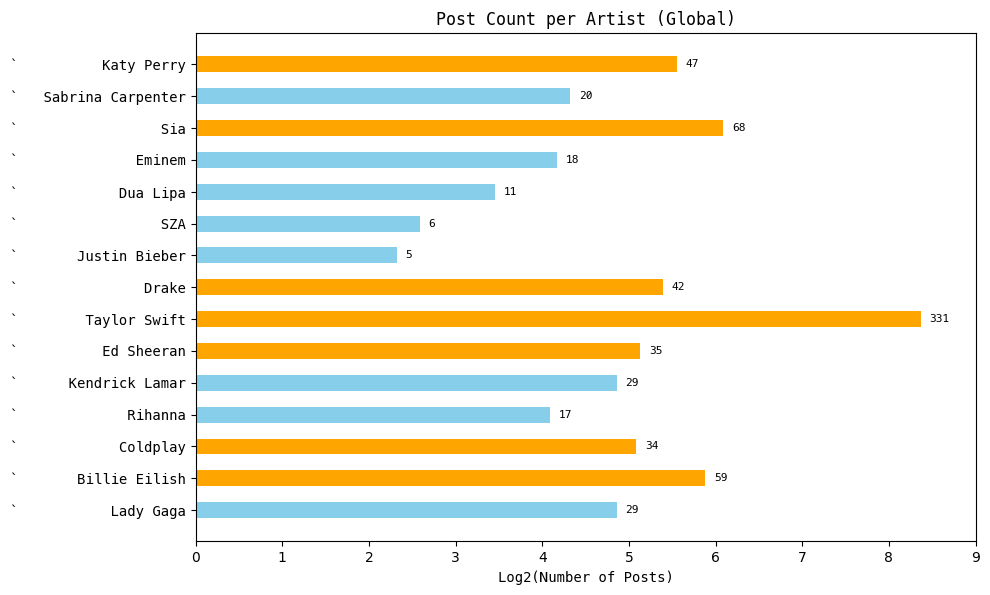

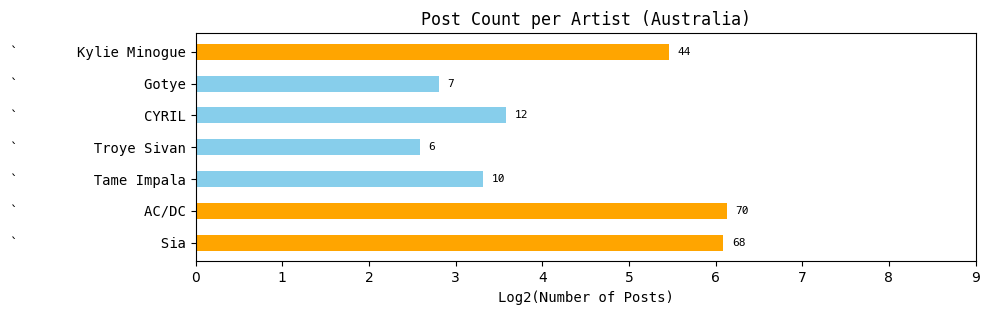

In [6]:
results_artists_5 = [(name, count) for name, count in count_via_api['international'] if count >= 5]
results_artists_au_5 = [(name, count) for name, count in count_via_api['australia'] if count >= 5]

print("Filtered Global Artists (≥5 posts):")
pprint(results_artists_5)
print(len(results_artists_5))

print("\nFiltered Australian Artists (≥5 posts):")
pprint(results_artists_au_5)
print(len(results_artists_au_5))

plot_results(results_artists_5, "Post Count per Artist (Global)", x_limit=9)
plot_results(results_artists_au_5, "Post Count per Artist (Australia)", x_limit=9)

### 6. Querying Artist Monthly Mention Trends via API

Send a GET request to API endpoint '/artist-mention-counts-trend'.

The query returns the  mention counts for each artist per month, stored into result_heatmap as a JSON response. 

In [7]:
warnings.simplefilter('ignore', InsecureRequestWarning)

# Analyser connection
headers = {"Content-Type": "application/json"}
try:
    response = requests.get(
        "http://localhost:9090/artist-mention-counts-trend",
        headers=headers,
        verify=False
    )
    if response.status_code == 200:
        result_heatmap = response.json()
        pprint(result_heatmap, sort_dicts=False)
        print(len(result_heatmap["mentions"]))
    else:
        print(f"Error: {response.status_code} {response.text}")
        result_heatmap = 0
except Exception as e:
    print(f"Request failed: {str(e)}")
    result = 0

{'mentions': {'5 Seconds of Summer': {},
              'AC/DC': {'202212': 1,
                        '202301': 0,
                        '202302': 0,
                        '202303': 1,
                        '202304': 2,
                        '202305': 1,
                        '202306': 1,
                        '202307': 3,
                        '202308': 2,
                        '202309': 3,
                        '202310': 2,
                        '202311': 3,
                        '202312': 2,
                        '202401': 4,
                        '202402': 4,
                        '202403': 3,
                        '202404': 0,
                        '202405': 1,
                        '202406': 3,
                        '202407': 3,
                        '202408': 2,
                        '202409': 1,
                        '202410': 2,
                        '202411': 2,
                        '202412': 1,
                        '202501': 

### 7. Organise Data into Lists Containing Names and Series of Monthly Post Counts in Sequence

In [8]:
start_month = datetime.strptime("2022-10", "%Y-%m")
end_month = datetime.strptime("2025-05", "%Y-%m")

# List of months in interest
months = []
cur = start_month
while cur <= end_month:
    months.append(cur.strftime("%Y%m"))
    cur += relativedelta(months=1)

# Global artists mentions
mention_monthly = []
artist_labels_global = []
for name_raw, _ in results_artists_5:
    name = name_raw.strip(" `")
    mention_monthly.append(result_heatmap["mentions"].get(name, {}))
    artist_labels_global.append(name_raw)

# AU artists mentions
mention_au_monthly = []
artist_labels_au = []
for name_raw, _ in results_artists_au_5:
    name = name_raw.strip(" `")
    mention_au_monthly.append(result_heatmap["mentions"].get(name, {}))
    artist_labels_au.append(name_raw)

print(len(mention_monthly))
print(len(artist_labels_global))
print(len(mention_au_monthly))
print(len(artist_labels_au))

15
15
7
7


### 8. Plot Monthly Mentions per Artist into Heatmap

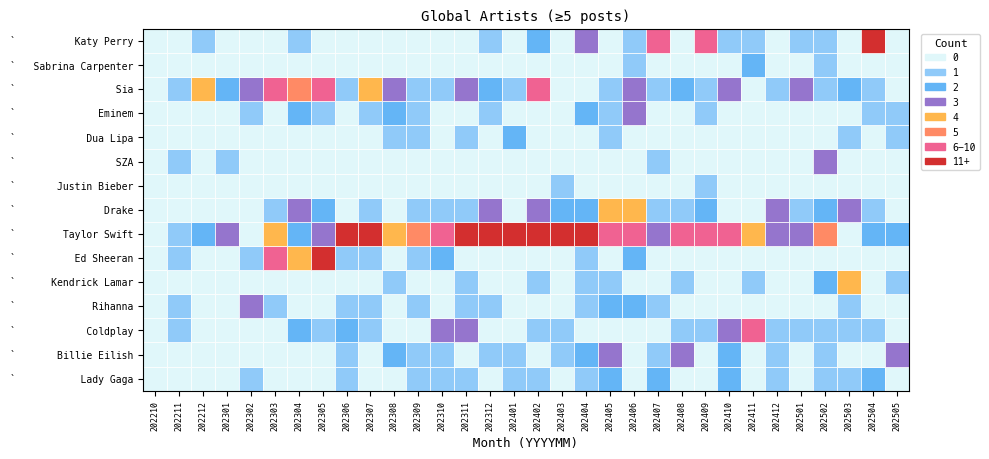

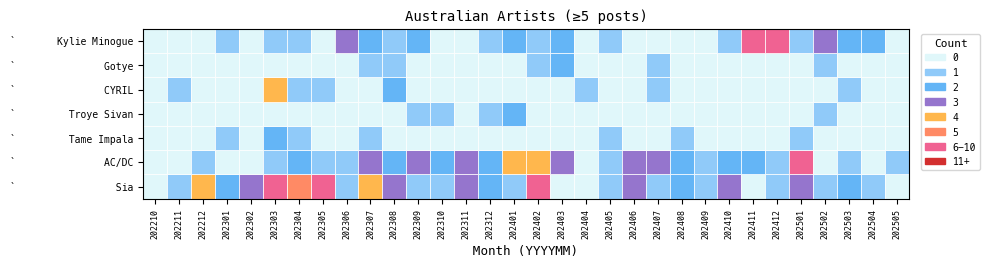

In [9]:
def get_color(value):
    if value == 0:
        return "#e0f7fa"
    elif value == 1:
        return "#90caf9"
    elif value == 2:
        return "#64b5f6"
    elif value == 3:
        return "#9575cd"
    elif value == 4:
        return "#ffb74d"
    elif value == 5:
        return "#ff8a65"
    elif 6 <= value <= 10:
        return "#f06292"
    else:
        return "#d32f2f"

def plot_heatmap(mentions_list, artist_labels, title=""):
    num_artists = len(mentions_list)  # Number of rows
    num_months = len(months)  # Number of columns

    # Initialise a 2D array to store mention counts per artist per month
    grid_counts = numpy.zeros((num_artists, num_months), dtype=int)

    # Populate the grid with counts from the input list of dictionaries
    for i, counts in enumerate(mentions_list):
        for j, month in enumerate(months):
            grid_counts[i, j] = counts.get(month, 0)  # Get count and handle KeyError
    # print(grid_counts)  # Check the matrix to be mapped into colors
    # Set up the figure and axes for plotting
    fig, ax = plt.subplots(figsize=(10, num_artists * 0.24 + 1.1))

    # Draw each rectangle of the heatmap
    for row in range(num_artists):
        for col in range(num_months):
            val = grid_counts[row, col]
            color = get_color(val)  # Map count to a colour
            # Add a coloured rectangle to the plot at the correct position
            rect = plt.Rectangle((col, row), 1, 1, facecolor=color, edgecolor="white", lw=0.5)
            ax.add_patch(rect)

    # Set plot limits
    ax.set_xlim(0, num_months)
    ax.set_ylim(0, num_artists)

    # Set x-axis ticks at the centre of each cell and label them with months
    ax.set_xticks([i + 0.5 for i in range(num_months)])
    ax.set_xticklabels(months, rotation=90, fontsize=6, fontname='Menlo', ha='center')

    # Set y-axis ticks at the centre of each row and label them with artist names
    ax.set_yticks([i + 0.5 for i in range(num_artists)])
    ax.set_yticklabels(artist_labels, fontsize=7, fontname='Menlo', va='center')

    legend_labels = [
        ("0", "#e0f7fa"),
        ("1", "#90caf9"),
        ("2", "#64b5f6"),
        ("3", "#9575cd"),
        ("4", "#ffb74d"),
        ("5", "#ff8a65"),
        ("6-10", "#f06292"),
        ("11+", "#d32f2f"),
    ]
    # Create coloured legend patches
    legend_handles = [mpatches.Patch(color=color, label=label) for label, color in legend_labels]

    # Add legend to the plot
    legend = ax.legend(
        handles=legend_handles,
        title="Count",
        title_fontsize=8,
        fontsize=7,
        bbox_to_anchor=(1.01, 1),
        loc='upper left'
    )

    # Apply custom font to legend title and labels
    plt.setp(legend.get_title(), fontname='Menlo')
    for text in legend.get_texts():
        text.set_fontname('Menlo')

    # Set optional title if provided
    if title:
        ax.set_title(title, fontname='Menlo', fontsize=10)

    # Add x-axis label
    ax.set_xlabel("Month (YYYYMM)", fontname='Menlo', fontsize=9)

    # Automatically adjust layout to fit content
    plt.tight_layout()
    # Show the plot
    plt.show()

# Plot
plot_heatmap(mention_monthly, artist_labels_global, title="Global Artists (≥5 posts)")
plot_heatmap(mention_au_monthly, artist_labels_au, title="Australian Artists (≥5 posts)")

### 9. Query Sentiments of Posts Related to Keyword

Since sentiment score is not directly stored in ES, querying from API endpoint only return a label ("positivr", "neutral", "negative").

For the purpose of plotting a numerical score, qquerying directly from ES is more convenient for the following cells.

In [10]:
url = "https://localhost:9200/artists/_search"
auth = HTTPBasicAuth("elastic", "elastic")
headers = {"Content-Type": "application/json"}

def calculate_sentiment_score(positive, negative, neutral):
    return (positive - negative) / (0.5 + neutral)

def query_sentiment_scores(keyword: str):
    query = {
        "size": 1000,
        "query": {
            "match_phrase": {
                "content": keyword
            }
        },
        "_source": [
            "_id",
            "roberta_sentiment.positive",
            "roberta_sentiment.negative",
            "roberta_sentiment.neutral",
            "created_at"
        ]
    }

    response = requests.post(url, headers=headers, auth=auth, json=query, verify=False)
    response.raise_for_status()
    data = response.json()

    results = {}
    for hit in data["hits"]["hits"]:
        _id = hit["_id"]
        source = hit.get("_source", {})
        sentiment = source.get("roberta_sentiment", {})
        neg = sentiment.get("negative", 0.0)
        neu = sentiment.get("neutral", 0.0)
        pos = sentiment.get("positive", 0.0)
        score = calculate_sentiment_score(pos, neg, neu)

        created_at = source.get("created_at", None)
        created_date = created_at[:10] if isinstance(created_at, str) else None  # Truncate to YYYY-MM-DD

        results[_id] = (keyword, neg, neu, pos, score, created_date)

    return results

if __name__ == "__main__":
    sentiment_results = query_sentiment_scores("ladygaga")
    pprint(sentiment_results, sort_dicts=False)
    print(len(sentiment_results))

{'109655577091090209': ('ladygaga',
                        0.04311734437942505,
                        0.33192208409309387,
                        0.6249606013298035,
                        0.6993963353968001,
                        '2023-01-08'),
 '112498546372780506': ('ladygaga',
                        0.7301734089851379,
                        0.2557957172393799,
                        0.014030924998223782,
                        -0.947534456271725,
                        '2024-05-24')}
2


### 10. Use Aliases as Keywords and Aggregate by Formal Names of Artists

In [11]:
def collect_artist_alias_scores(artist_dict):
    detailed_artist_scores = {}
    for name, aliases in artist_dict.items():
        name_dict = {}
        for alias in aliases:
            alias_dict = query_sentiment_scores(alias)
            name_dict.update(alias_dict)  # Merge posts across aliases, avoiding duplication by post ID
        detailed_artist_scores[name] = name_dict
    return detailed_artist_scores


def compute_avg_sentiment(detailed_artist_scores):
    sentiment_list = []
    for name, name_dict in detailed_artist_scores.items():
        if name_dict:
            score_avg = sum(entry[-2] for entry in name_dict.values()) / len(name_dict)
        else:
            score_avg = 0.0
        sentiment_list.append((name, score_avg))
    return sentiment_list


cleaned_json_path = "artists_cleaned.json"
with open(cleaned_json_path, "r", encoding="utf-8") as f:
    cleaned_artist_data = json.load(f)

detailed_scores = collect_artist_alias_scores(cleaned_artist_data["artists"])
detailed_scores_au = collect_artist_alias_scores(cleaned_artist_data["artists_au"])

# pprint(detailed_scores, sort_dicts=False)
# pprint(detailed_scores_au, sort_dicts=False)

avg_sentiment = compute_avg_sentiment(detailed_scores)
avg_sentiment_au = compute_avg_sentiment(detailed_scores_au)

pprint(avg_sentiment, sort_dicts=False)
pprint(avg_sentiment_au, sort_dicts=False)

[('Lady Gaga', -0.08380464742303667),
 ('Billie Eilish', 0.3064817836699785),
 ('Coldplay', -0.016496038297192168),
 ('Rihanna', 0.5385766165350465),
 ('Kendrick Lamar', -0.046272379446281736),
 ('Ed Sheeran', 0.10528650003998699),
 ('Taylor Swift', -0.028148661937558776),
 ('Drake', 0.10892895267840572),
 ('Justin Bieber', -0.44136069492083774),
 ('SZA', 0.3113976803329795),
 ('Dua Lipa', 0.5695610840116538),
 ('Eminem', -0.139196342427793),
 ('Sia', -0.11919282936760356),
 ('Sabrina Carpenter', 0.12418926679571349),
 ('Katy Perry', -0.40121171800991423)]
[('Sia', -0.11919282936760356),
 ('AC/DC', 0.11507098032564994),
 ('Tame Impala', 0.041266844446582504),
 ('Troye Sivan', 0.3786239481481979),
 ('CYRIL', -0.11682412801506625),
 ('Gotye', 0.1008419694540971),
 ('Kylie Minogue', 0.11149589527751336)]


### 11. Plot Average Sentiment Scores by Artists and Compare Global vs Australian

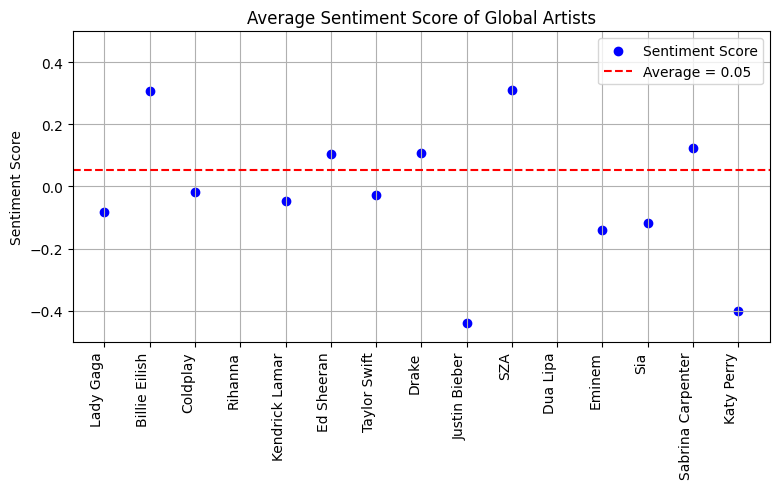

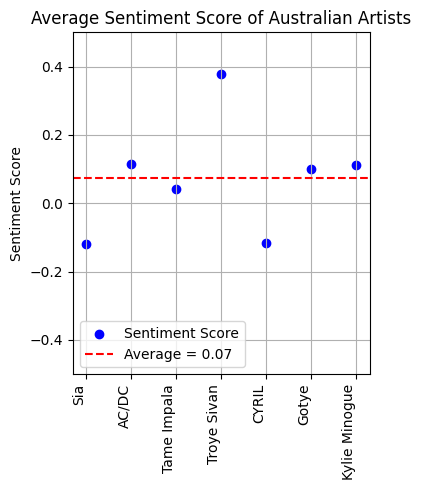

In [12]:
def plot_sentiments(data, title):
    names, scores = zip(*data)
    avg_score = sum(scores) / len(scores)

    plt.figure(figsize=(len(data) * 0.5 + 0.4, 5))
    plt.scatter(names, scores, color="blue", label="Sentiment Score")
    plt.axhline(avg_score, color="red", linestyle="--", label=f"Average = {avg_score:.2f}")
    plt.ylim(-0.5, 0.5)
    plt.xticks(rotation=90, ha="right")
    plt.ylabel("Sentiment Score")
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


plot_sentiments(avg_sentiment, "Average Sentiment Score of Global Artists")
plot_sentiments(avg_sentiment_au, "Average Sentiment Score of Australian Artists")

In [14]:
scores_global = [x[1] for x in avg_sentiment]
scores_au = [x[1] for x in avg_sentiment_au]

# t test
t_stat, p_value = ttest_ind(scores_global, scores_au, equal_var=False)  # Welch’s t-test

print(f"T-statistic: {t_stat:.3f}, P-value: {p_value:.3f}")

T-statistic: -0.207, P-value: 0.839


### 12. Plot Trends of Seasonal Sentiment Scores of Each Artist

Interactivity: Note that clicking on legend can hide/reveal the trend line representing an individual artist, enabled by plotly.express.

In [13]:
def preprocess_scores(detailed_scores):
    """
    Converts detailed_scores into:
    { artist: [(month_str, score), ...] }
    """
    simplified = {}
    for artist, posts in detailed_scores.items():
        simplified[artist] = []
        for post in posts.values():
            score = post[4]
            date_str = post[5]
            if date_str:
                try:
                    month_str = datetime.strptime(date_str, "%Y-%m-%d").strftime("%Y-%m")
                    simplified[artist].append((month_str, score))
                except Exception:
                    continue
    return simplified

def convert_to_dataframe(simplified_scores):
    records = []
    for artist, data in simplified_scores.items():
        for month, score in data:
            records.append({'artist': artist, 'month': month, 'sentiment': score})
    return pandas.DataFrame(records)

def get_quarter_label(date_obj):
    quarter = (date_obj.month - 1) // 3 + 1
    return f"{date_obj.year}S{quarter}"

def average_by_quarter(df, start_month, end_month):
    df['month'] = pandas.to_datetime(df['month'])
    df['quarter'] = df['month'].apply(get_quarter_label)

    grouped = df.groupby(['artist', 'quarter'])['sentiment'].mean().reset_index()

    quarters = []
    current = start_month
    while current <= end_month:
        quarters.append(get_quarter_label(current))
        current += relativedelta(months=3)
    full_index = pandas.MultiIndex.from_product(
        [grouped['artist'].unique(), quarters],
        names=['artist', 'quarter']
    )
    grouped = grouped.set_index(['artist', 'quarter']).reindex(full_index, fill_value=0).reset_index()
    return grouped

def plot_interactive(df, title):
    fig = px.line(
        df,
        x='quarter',
        y='sentiment',
        color='artist',
        markers=True,
        title=title,
        labels={"sentiment": "Sentiment Score", "quarter": "Quarter"},
        template="plotly_white"
    )
    fig.update_layout(
        yaxis=dict(range=[-2, 2]),
        xaxis=dict(fixedrange=True),
        dragmode=False,
        xaxis_tickangle=-45,
        legend_title="Artist (click to show/hide)",
        height=500
    )
    fig.show()

start_month = datetime.strptime("2022-10", "%Y-%m")
end_month = datetime.strptime("2025-05", "%Y-%m")

simplified_global = preprocess_scores(detailed_scores)
simplified_au = preprocess_scores(detailed_scores_au)

# Convert to DataFrame and find quarterly averages
df_global = convert_to_dataframe(simplified_global)
df_avg_global = average_by_quarter(df_global, start_month, end_month)

df_au = convert_to_dataframe(simplified_au)
df_avg_au = average_by_quarter(df_au, start_month, end_month)

# Plot
plot_interactive(df_avg_global, "Quarterly Sentiment Trend (Global Artists)")
plot_interactive(df_avg_au, "Quarterly Sentiment Trend (Australian Artists)")